In [2]:
import nbimporter
import numpy as np

from Aufgabe_2 import HHSimulationOdeint, HHModel, HHParameters

In [3]:
params = HHParameters()
hh_model = HHModel(params)

In [4]:
possible_patterns = [[1, 1, 0, 0], [1, 0, 1, 0], [1, 0, 0, 1], [0, 1, 1, 0], [0, 1, 0, 1], [0, 0, 1, 1]]
good_pattern = [1, 0, 0, 1]

training_data_length = 25
training_data = np.zeros((training_data_length, 4), dtype=int)

# updates the global training_data variable with new patterns
def make_new_training_data():
    for i in range(training_data_length):
        pattern = np.array([1, 1, 0, 0])
        
        # extra 40% chance of using the good pattern, so that the network can learn to recognize the good pattern
        if np.random.rand() < 0.4:
            pattern = good_pattern
        else: 
            np.random.shuffle(pattern)

        training_data[i] = pattern

make_new_training_data()

We create a NN with 4 input neurons and 1 output neuron

In [5]:
class NN_5_Neurons:

    # weights is a vector of length 4
    def __init__(self, weights):
        self.weights = np.array(weights)

    @staticmethod
    def getInputCurrent(weightedSum):
        def I_ext(t):
            return  6 * weightedSum if t < 1 else -5
        return I_ext

    @staticmethod
    def sigmoid(x):
        return 1 / (1 + np.exp(-x))

    def is14DiagonalBlack(self, pattern):
        weightedSum = np.dot(self.weights, pattern)
        I_ext = self.getInputCurrent(weightedSum)

        _, U, _, _, _ = HHSimulationOdeint(hh_model, time=10, dt=0.01, I_ext=I_ext).run()

        return self.sigmoid(max(U) / 10)

# good weights to recognize the pattern 'good_pattern' 
good_weights = np.copy(good_pattern)

nn_ones = NN_5_Neurons(weights=[1, 1, 1, 1])
results_ones = [nn_ones.is14DiagonalBlack(pattern) for pattern in possible_patterns]

print(f"results for NN with 1 as all weights: {results_ones}")

nn_good = NN_5_Neurons(good_weights)
results_good = [nn_good.is14DiagonalBlack(pattern) for pattern in possible_patterns]

print(f"results for NN with good weights: {results_good}")

print(f"perfect results: {[1 if pattern == good_pattern else 0 for pattern in possible_patterns]}")

results for NN with 1 as all weights: [0.9802052204143038, 0.9802052204143038, 0.9802052204143038, 0.9802052204143038, 0.9802052204143038, 0.9802052204143038]
results for NN with good weights: [0.002499846102356341, 0.002499846102356341, 0.9802052204143038, 0.0015016926560934998, 0.002499846102356341, 0.002499846102356341]
perfect results: [0, 0, 1, 0, 0, 0]


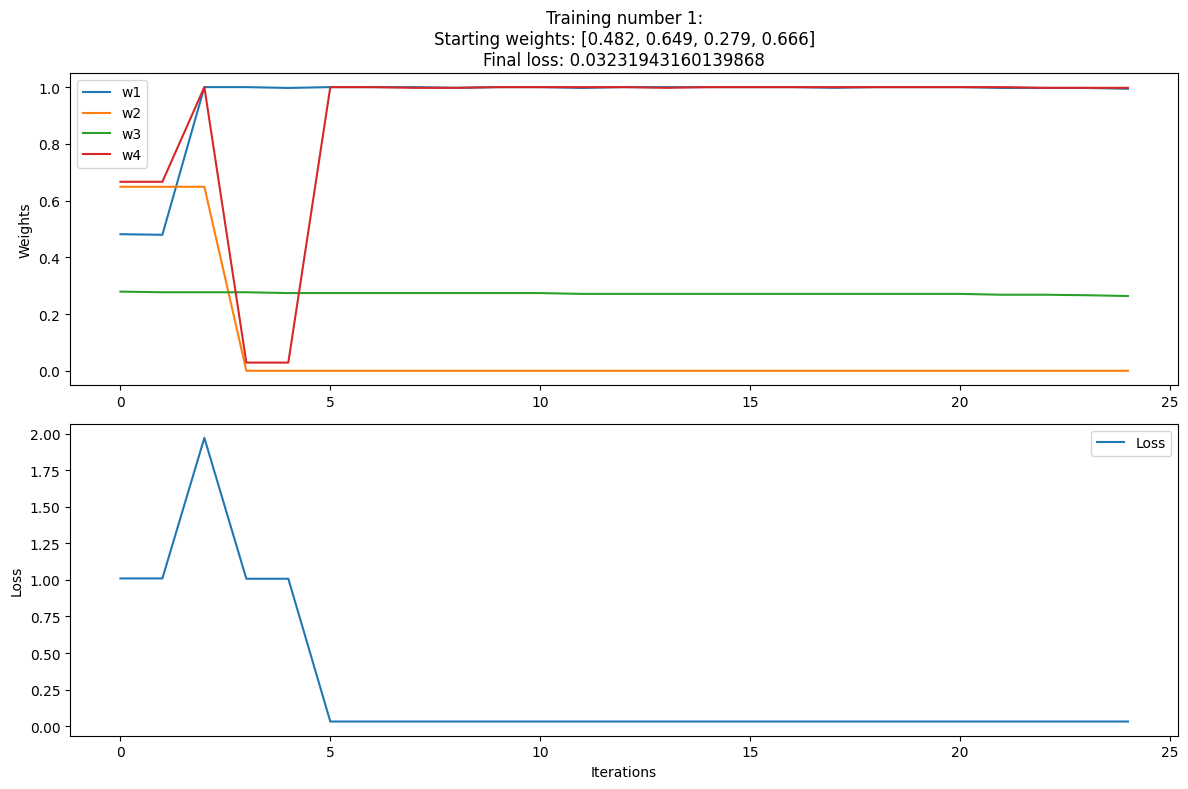

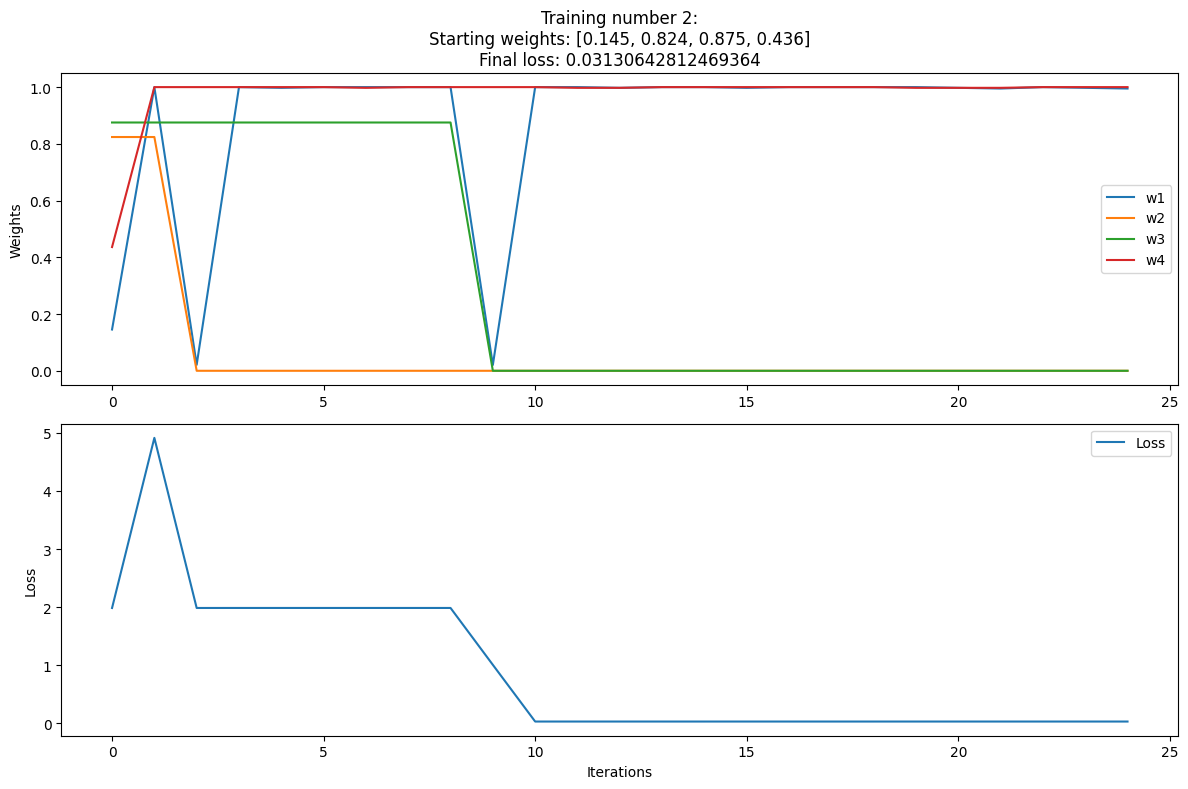

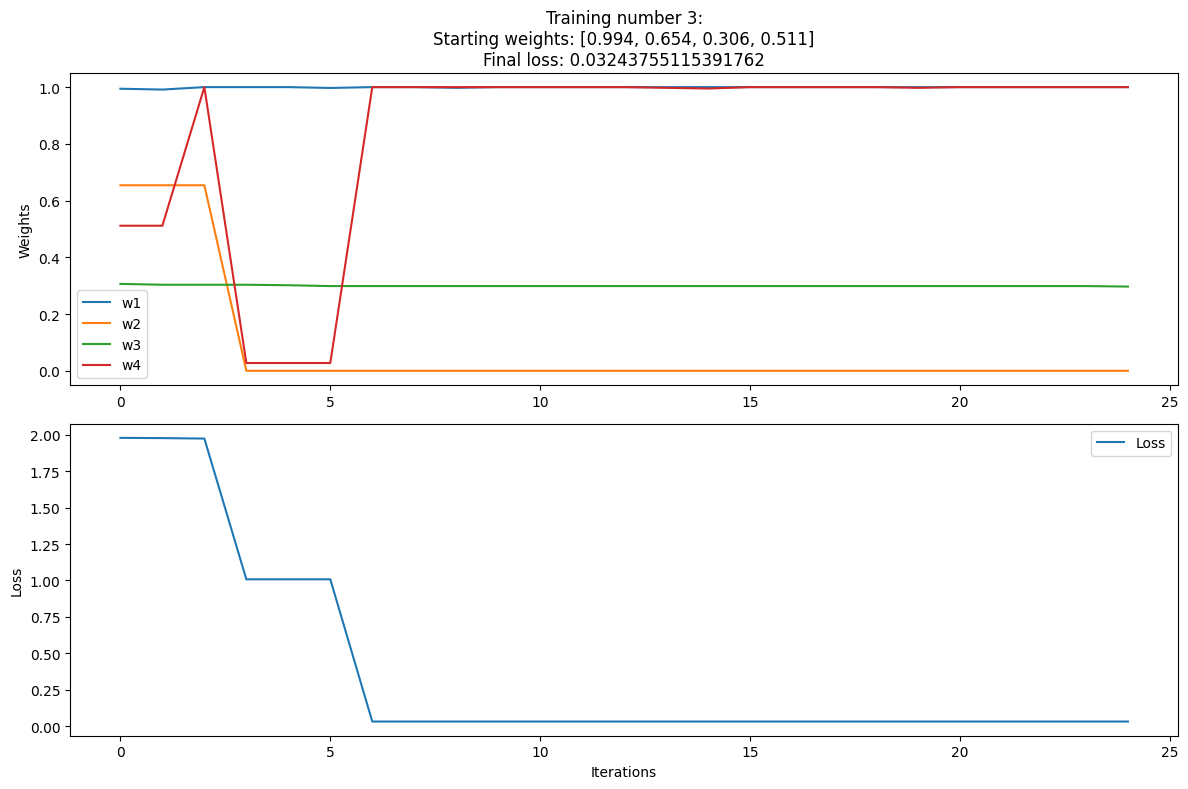

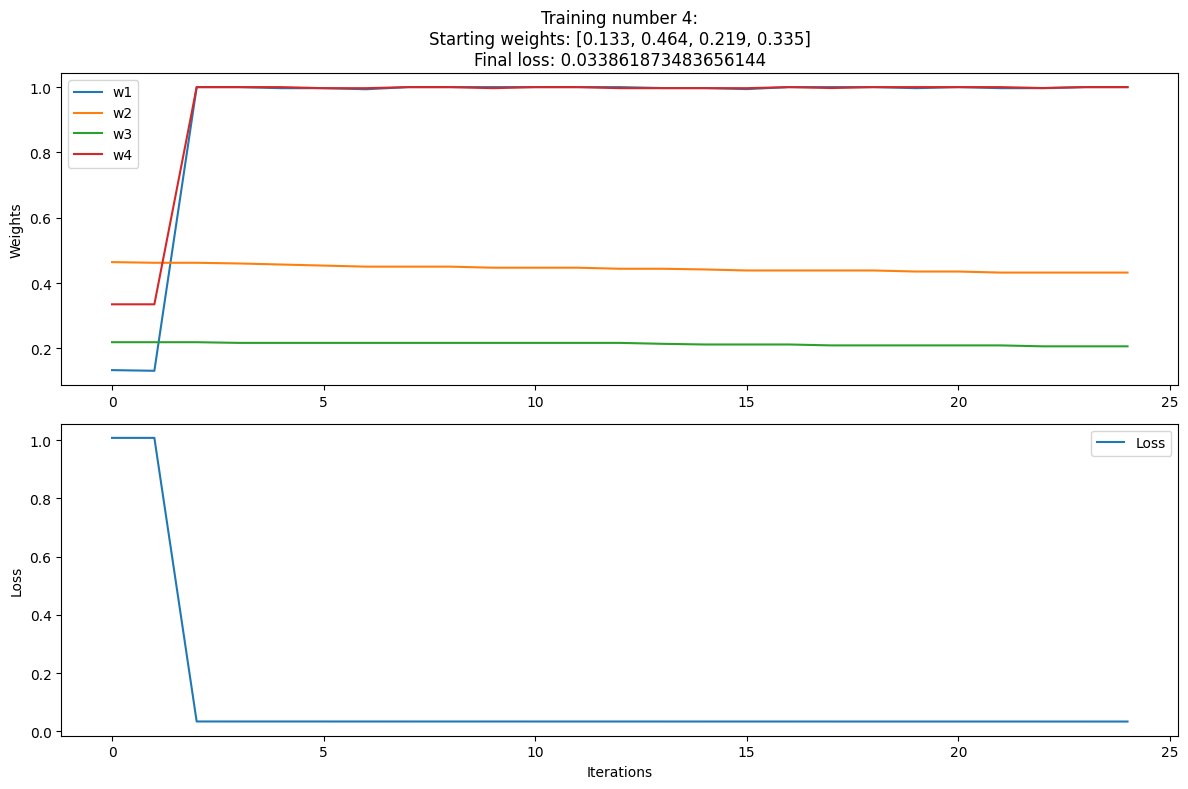

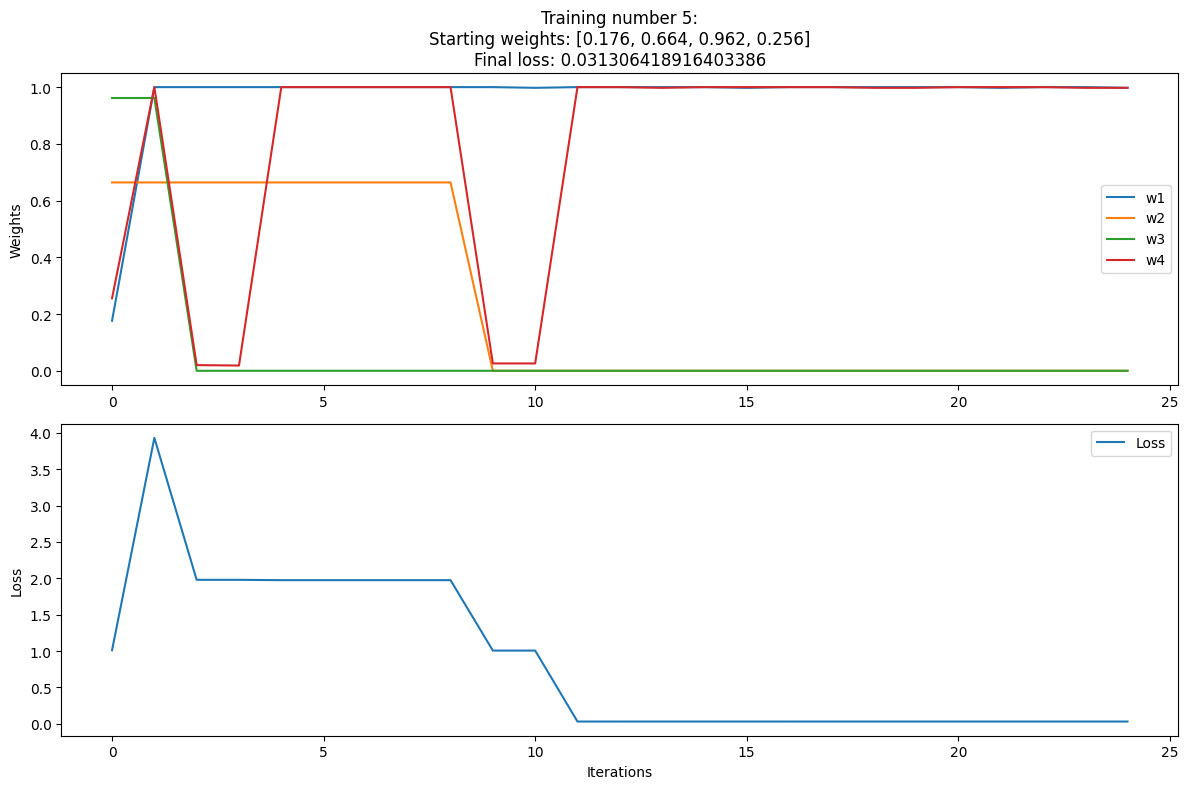

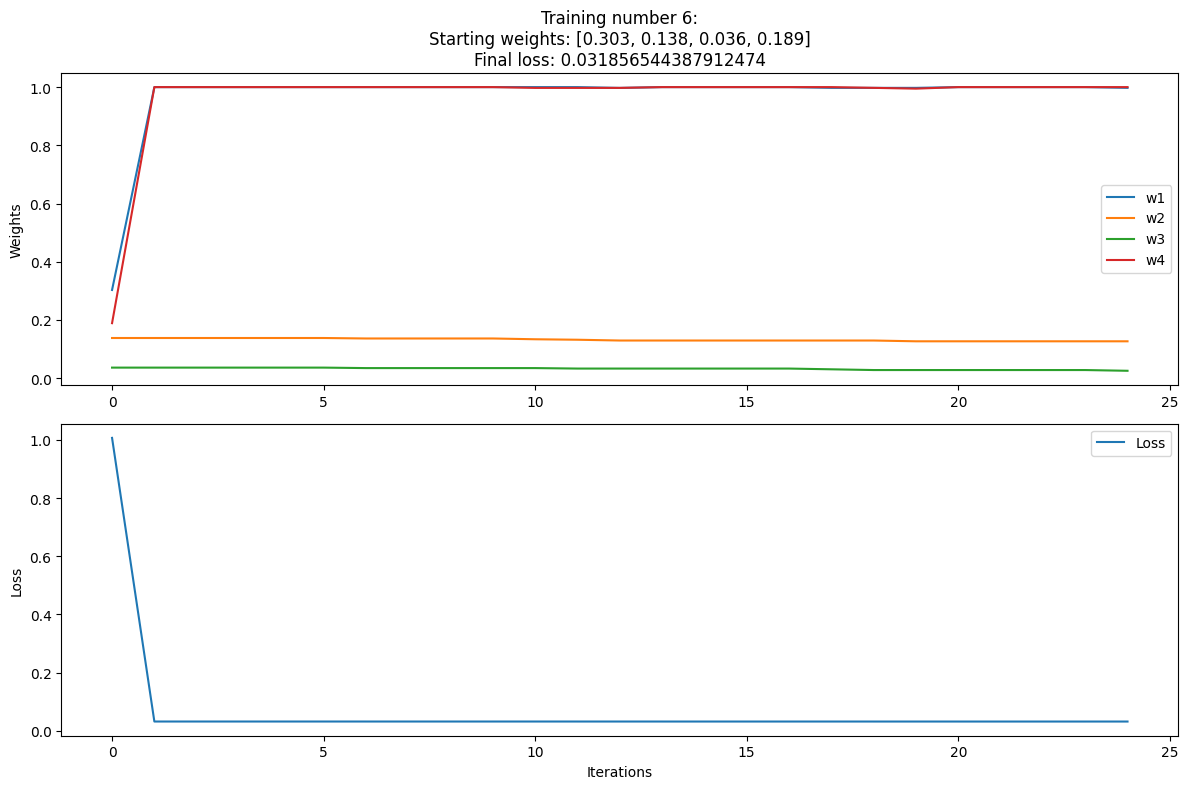

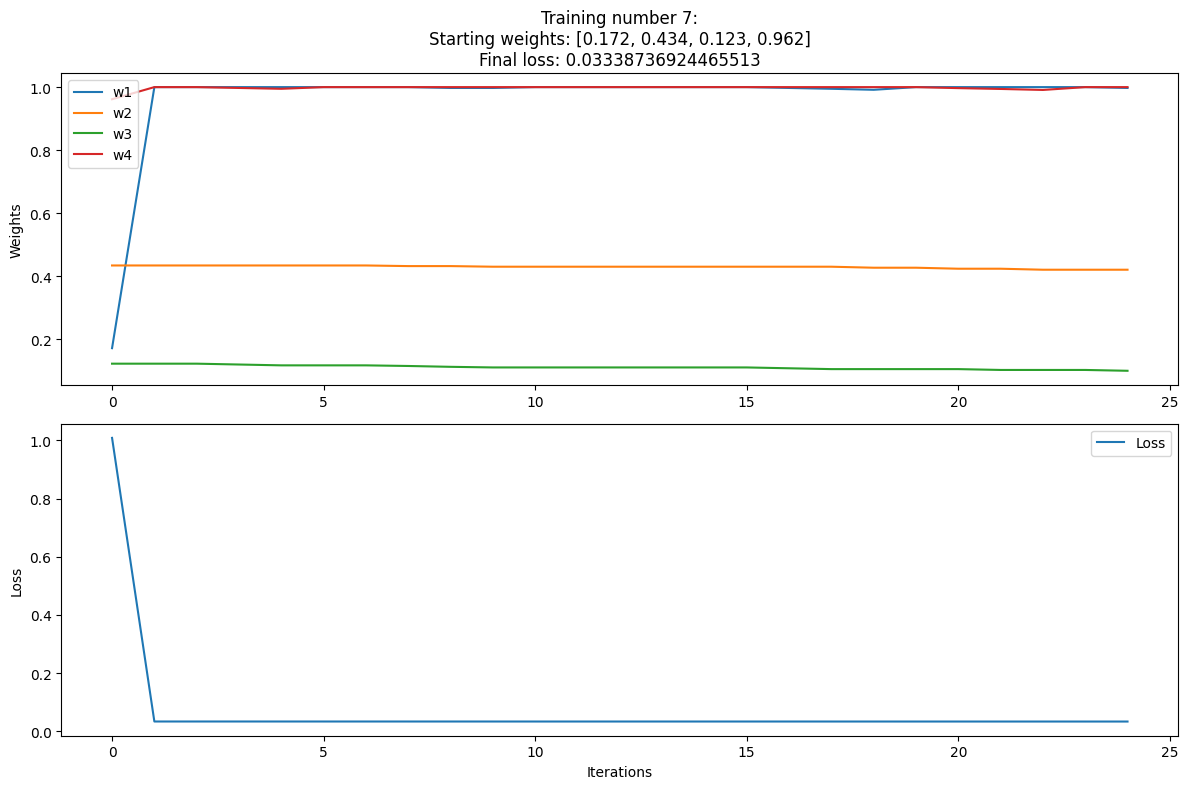

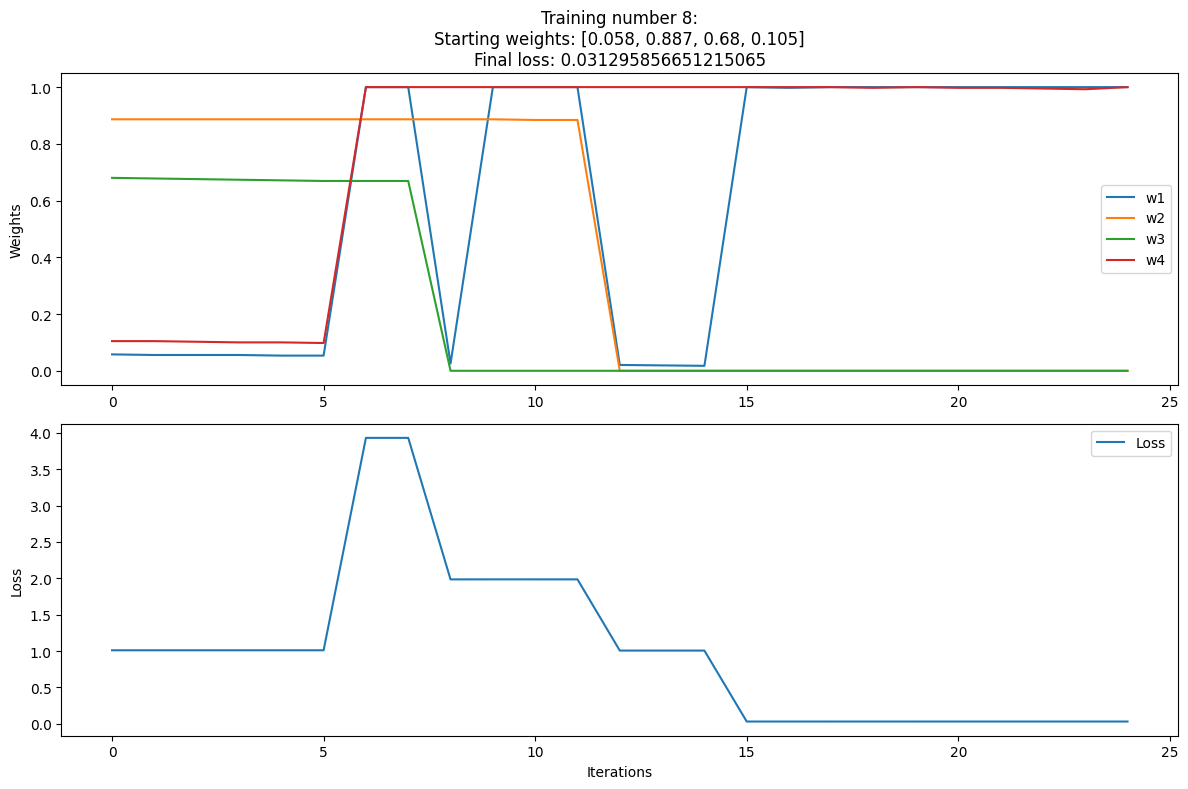

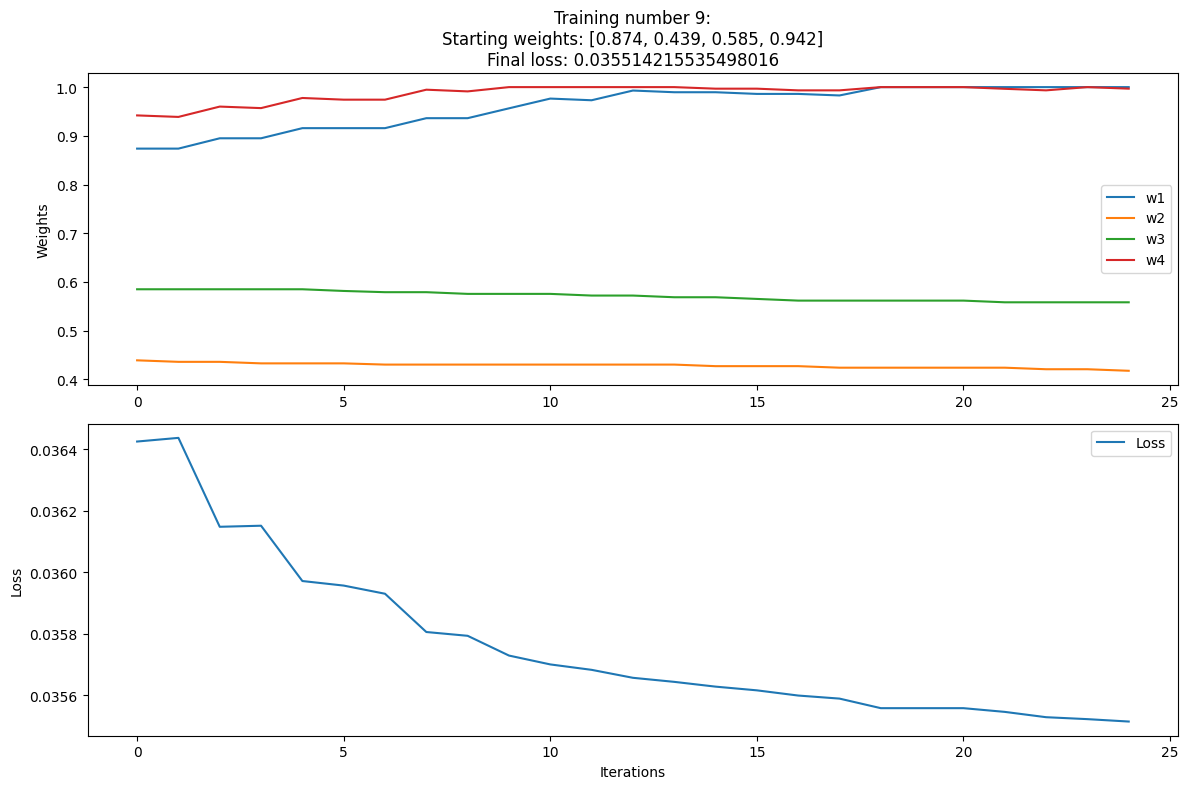

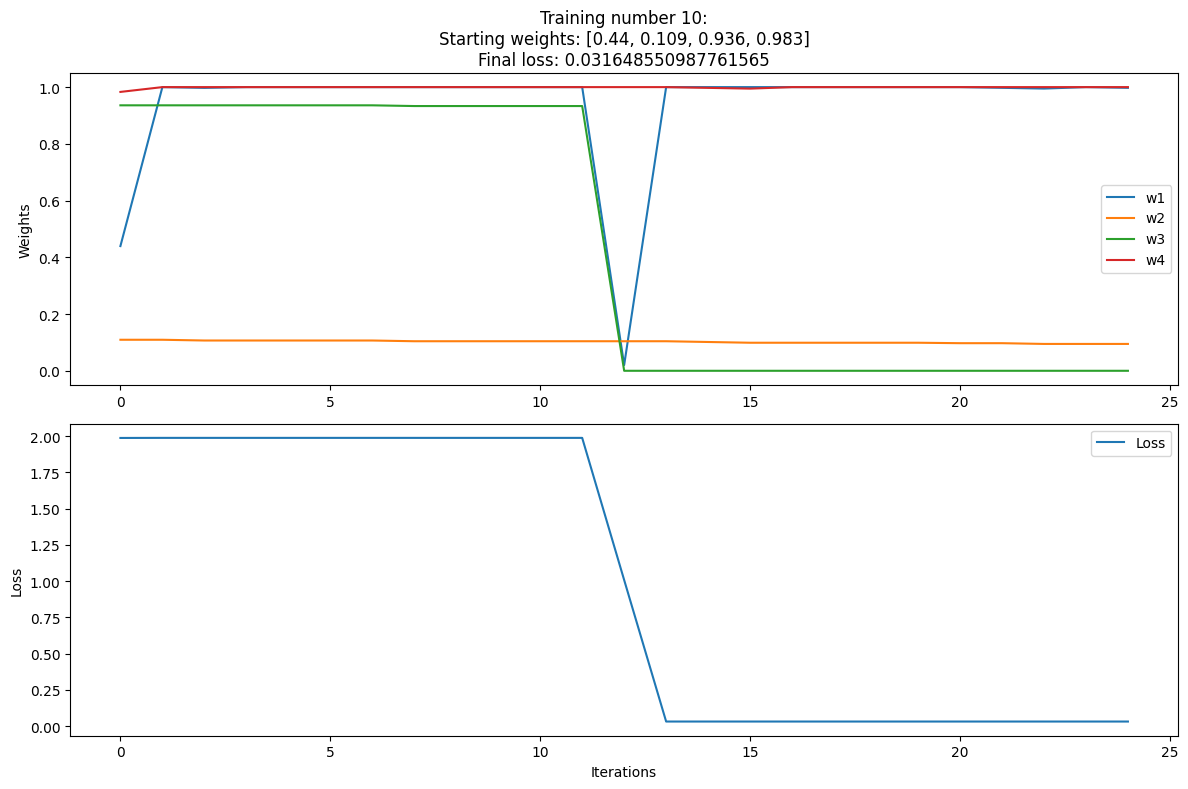

biggest loss after training: 0.035514215535498016


In [7]:
import matplotlib.pyplot as plt


# loss_for_single_pattern can be positive and negative, corresponding to undershooting and overshooting the correct result,
# this will tell if the weights have to be increased or decreased in training
def loss_for_single_pattern(weights, pattern):
    nn = NN_5_Neurons(weights)
    return np.array_equal(pattern, good_pattern) - nn.is14DiagonalBlack(pattern)

# loss_total > 0 
def loss_total(weights):
    return sum(abs(np.array([loss_for_single_pattern(weights, pattern) for pattern in possible_patterns])))


def training():
    weights = np.random.rand(4)

    # we record the total loss and the weights after each training step:
    losses_during_training = np.array([0.] * training_data_length)
    weights_during_training = np.array([weights] * training_data_length)

    for i, pattern in enumerate(training_data):
        loss = loss_for_single_pattern(weights, pattern)

        losses_during_training[i] = loss_total(weights)
        weights_during_training[i] = weights

        # the weights that contributed to the loss are the ones that got 1 as input
        # those weights get decreased or increased depending on loss < 0 or loss > 0
        # the change in those weights is proportional to the absolute value of the loss 
        weights += loss * pattern
        weights = np.clip(weights, 0, 1)

    return losses_during_training, weights_during_training


biggest_final_loss = 0

for i in range(10):
    losses, weights = training()

    biggest_final_loss = max(biggest_final_loss, losses[-1])

    # we make new random training data to demonstrate robustness to changes in the training data set
    make_new_training_data()

    # Plot der Entwicklung des losses und der weights
    plt.figure(figsize=(12, 8))

    # Weights
    plt.subplot(2, 1, 1)
    plt.title(f"Training number {i + 1}:\nStarting weights: {list(np.round(weights[0], 3))}\nFinal loss: {losses[-1]}")

    plt.plot(weights[:, 0], label="w1")
    plt.plot(weights[:, 1], label="w2")
    plt.plot(weights[:, 2], label="w3")
    plt.plot(weights[:, 3], label="w4")

    plt.ylabel("Weights")
    plt.legend()

    # Loss
    plt.subplot(2, 1, 2)
    plt.plot(losses, label="Loss")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.legend()

    plt.tight_layout()
    plt.show()

print(f"biggest loss after training: {biggest_final_loss}")